In [1]:
from pathlib import Path
import time
import torch
import numpy as np
import pandas as pd
from dataset import LinearDynamicalDataset, WHDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
#import plotly.graph_objects as go
from transformer_onestep import GPTConfig, GPT
import tqdm
import argparse
import metrics

In [2]:
fig_path = Path("fig")
fig_path.mkdir(exist_ok=True)

In [3]:
# Fix all random sources to make script fully reproducible
torch.manual_seed(420)
np.random.seed(430)
system_seed = 430 # Controls the system generation
data_seed = 0 # Control the input generation

In [4]:
# Overall settings
out_dir = "out"

# System settings
nu = 18
ny = 14
#seq_len = 600
batch_size = 64 # 256


# Compute settings
cuda_device = "cuda:1"
no_cuda = True
threads = 5
compile = False

# Configure compute
torch.set_num_threads(threads) 
use_cuda = not no_cuda and torch.cuda.is_available()
device_name  = cuda_device if use_cuda else "cpu"
device = torch.device(device_name)
device_type = 'cuda' if 'cuda' in device_name else 'cpu' # for later use in torch.autocast

torch.set_float32_matmul_precision("high")
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn

In [7]:
# Create out dir
out_dir = Path(out_dir)
#exp_data = torch.load(out_dir/"ckpt_onestep_wh_medium.pt", map_location=device)
exp_data = torch.load(out_dir/"ckpt_nu18_nu14_seq_len600.pt", map_location=device)


In [8]:
seq_len = exp_data["cfg"].seq_len
nx = exp_data["cfg"].nx

In [9]:
model_args = exp_data["model_args"]
gptconf = GPTConfig(**model_args)
model = GPT(gptconf).to(device)


state_dict = exp_data["model"]
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict);

number of parameters: 23.31M


In [10]:
from torch.utils.data import random_split
import os   

parent_folder = os.path.join(os.getcwd(), os.pardir) 
parent_folder = os.path.abspath(parent_folder)

if exp_data["cfg"].Manuel_pc:
    relative_folder = "isaacgym/python/examples/Franka/out_tensors/test"
else:
    relative_folder = "Data_generation/python/examples/Franka/out_tensors/test"

tensors_path = os.path.join(parent_folder,relative_folder ) 
tensors_path = os.path.abspath(tensors_path)

list_of_available_tensors = os.listdir(tensors_path)

print("These are the available files in "+str(tensors_path) +":\n")
for i in range(len(list_of_available_tensors)):
    single_pt_file_path = os.path.join(tensors_path, list_of_available_tensors[i]) 
    print("--> ",list_of_available_tensors[i])

# -------------------------------------------------------------------------------------------------------- # 

index_test = int(np.ceil(torch.rand(1).uniform_(0,int(len(list_of_available_tensors)-1)).numpy()))

single_pt_file_path = os.path.join(tensors_path, list_of_available_tensors[index_test]) 

print(" \n TESTING ON: ", list_of_available_tensors[index_test])

These are the available files in /home/manuel/isaacgym/python/examples/Franka/out_tensors/test:

-->  seed_290_envs_2048_steps_1000_f_5_input_MS_rand_1010.pt
-->  seed_838_envs_2048_steps_1000_f_5_input_MS_rand_1010.pt
-->  seed_102_envs_2048_steps_1000_f_5_input_MS_rand_1010.pt
 
 TESTING ON:  seed_838_envs_2048_steps_1000_f_5_input_MS_rand_1010.pt


In [11]:
loaded = torch.load(single_pt_file_path,map_location=device) #

@ torch.no_grad()
def loading():
    control_action_extracted = loaded['control_action']
    position_extracted = loaded['position']
    position = torch.movedim(position_extracted.to('cpu'),-2,-3)
    control_action = torch.movedim(control_action_extracted.to('cpu'),-2,-3)
    
    control_action = control_action[:,:exp_data["cfg"].block_size,:]
    position = position[:,:exp_data["cfg"].block_size,:]            # take the steps on which was trained on!
    return control_action,position

control_action,position = loading()
print(control_action.shape)
print(position.shape)

torch.Size([1975, 600, 18])
torch.Size([1975, 600, 14])


In [19]:

train_dataset = torch.utils.data.TensorDataset(position, control_action)

split_ratio = 0.8
train_size = int(split_ratio * len(train_dataset))
test_size = len(train_dataset) - train_size

train_ds, test_ds = random_split(train_dataset, [train_size, test_size])
test_dl = DataLoader(test_ds, batch_size=exp_data["cfg"].batch_size, num_workers=0)

In [20]:
batch_y, batch_u = next(iter(test_dl))
batch_y = batch_y.to(device)
batch_u = batch_u.to(device)
with torch.no_grad():
    batch_y_pred, loss = model(batch_u, batch_y)
    batch_y_pred = batch_y_pred.to("cpu").detach().numpy()
    batch_y = batch_y.to("cpu").detach().numpy()
    batch_u = batch_u.to("cpu").detach().numpy()

In [21]:
batch_y_target = batch_y[:, 1:, :] # target @ time k: y_{k+1}
batch_y_pred = batch_y_pred[:, :-1, :] # prediction @ time k: y_{k+1|k}
batch_y_pred_dummy = batch_y[:, :-1, :] # dummy estimator: y_{k+1} \approx y_{k}
batch_pred_err = batch_y_target - batch_y_pred
batch_pred_err_dummy = batch_y_target - batch_y_pred_dummy

t = np.arange(1, batch_y.shape[1])

2023-11-15 16:41:16


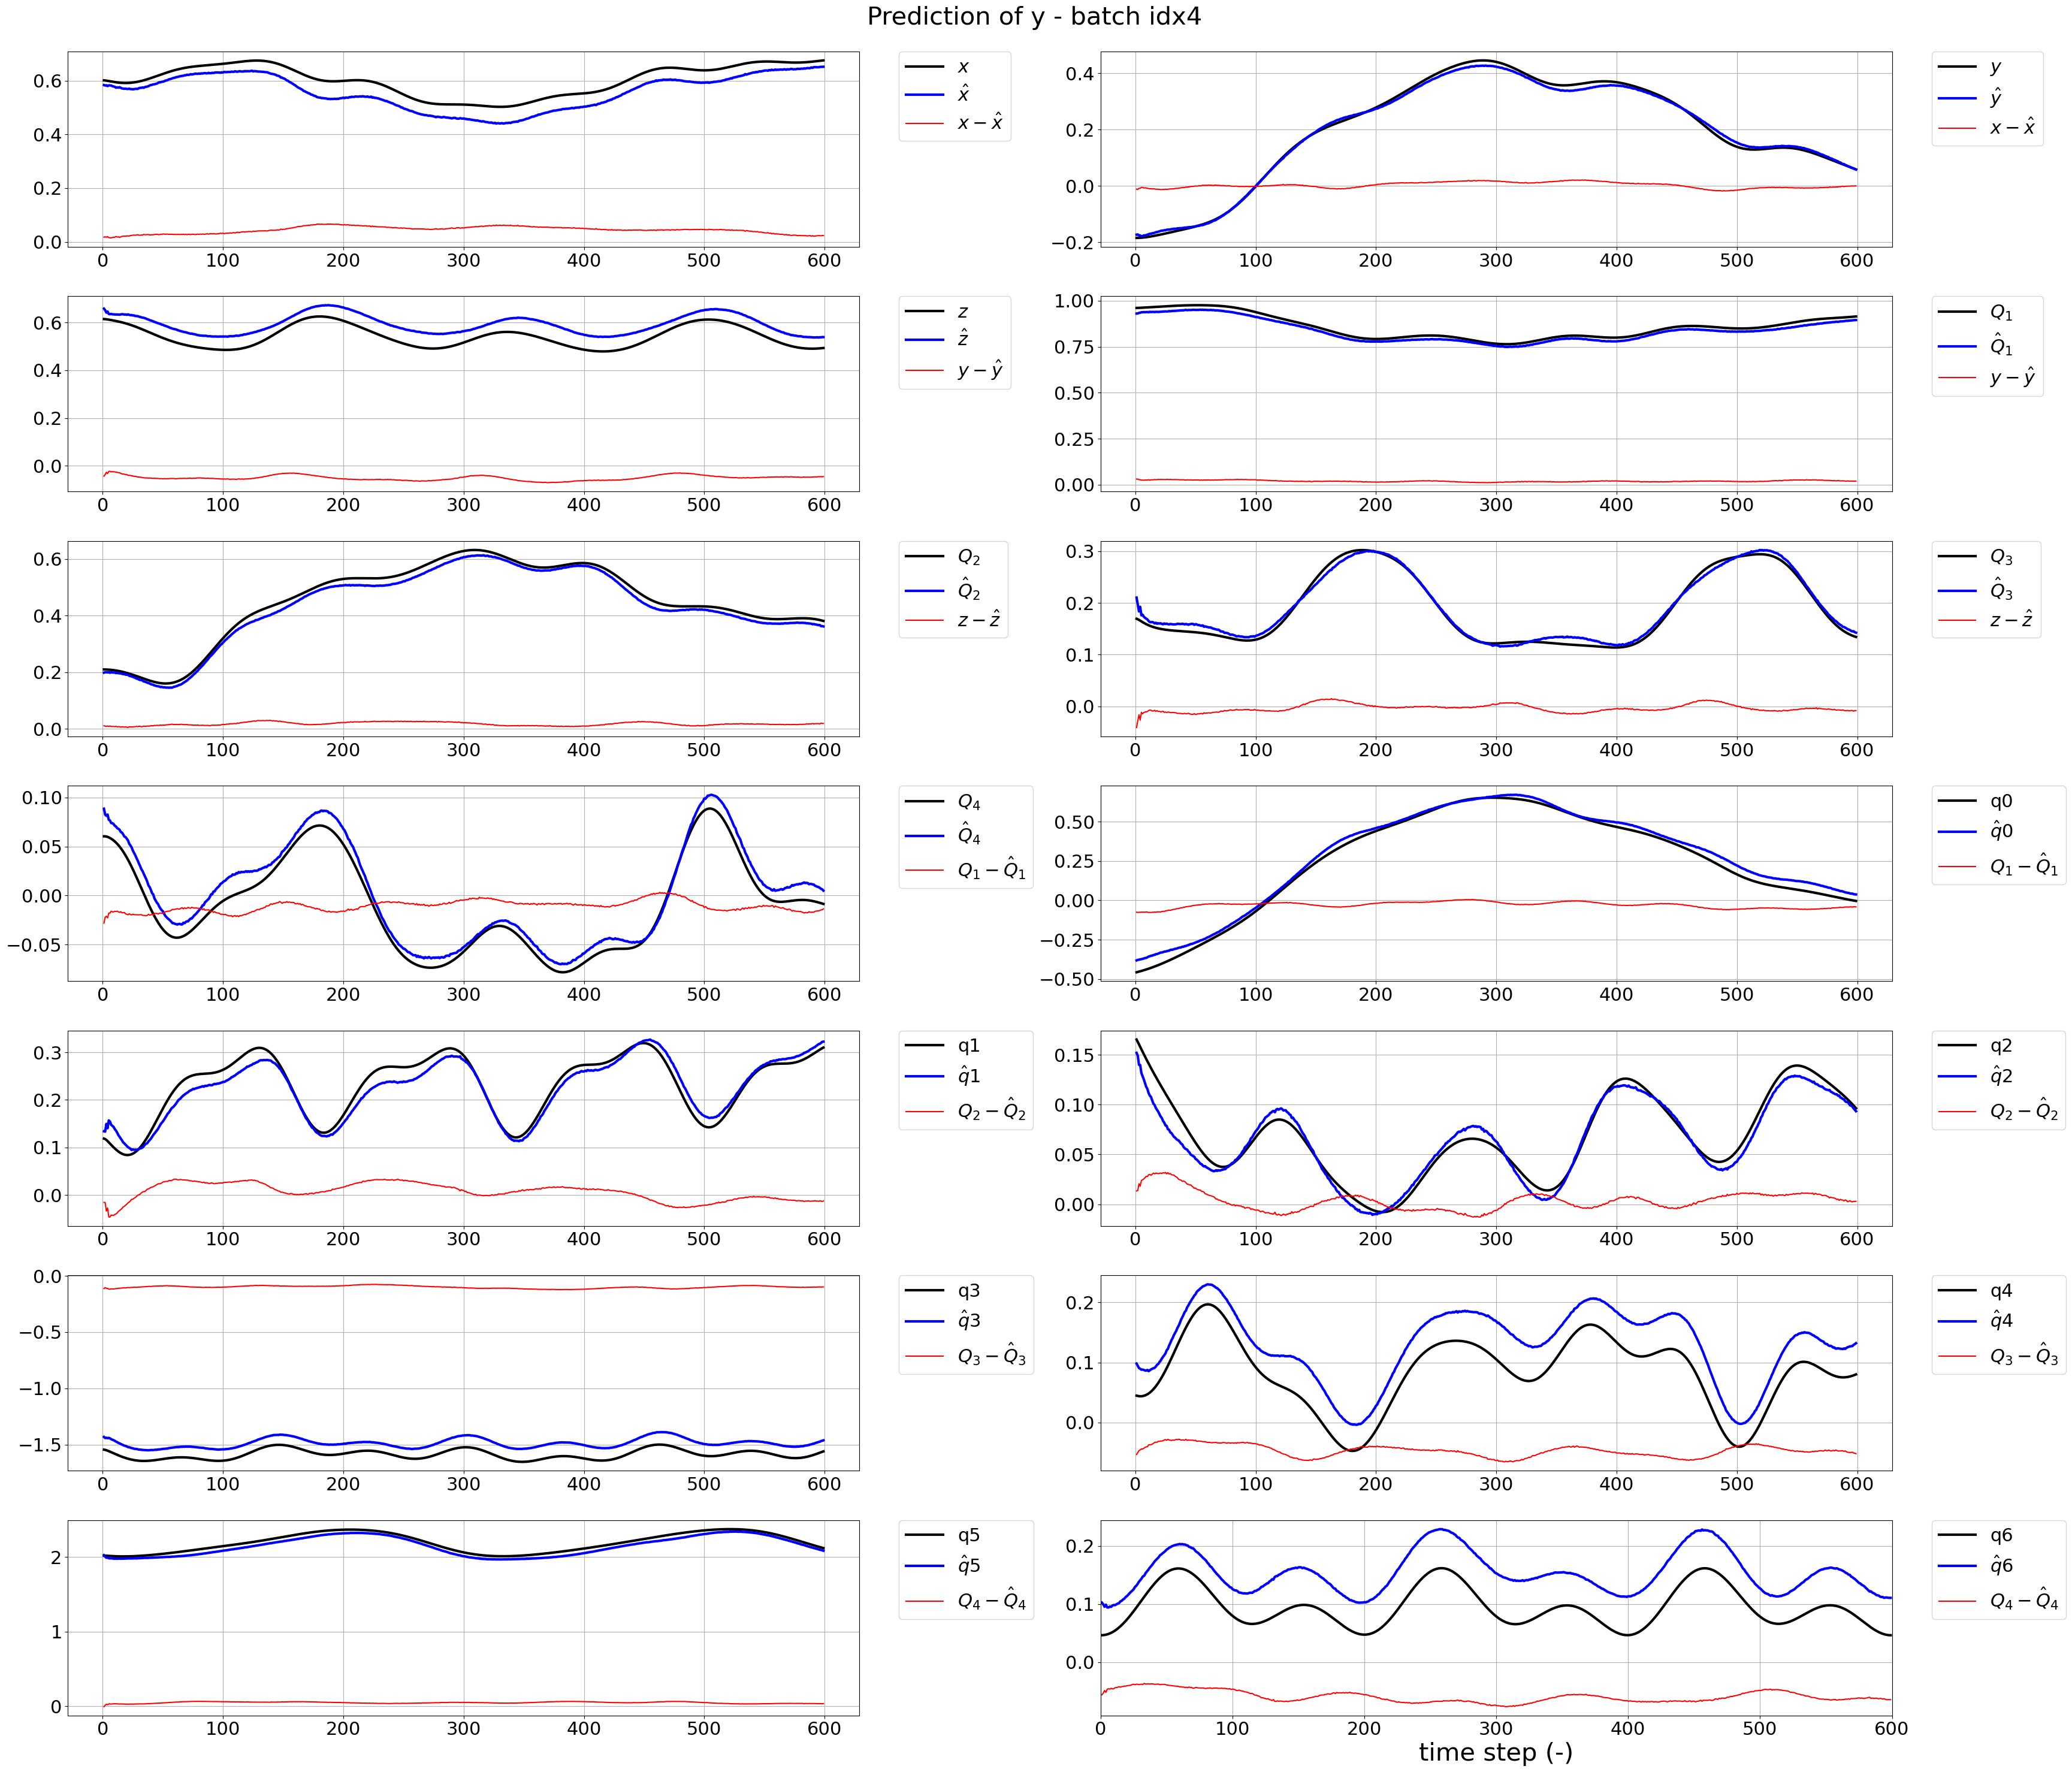

In [15]:
save_figure = True

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 22}

plt.rc('font', **font)

fig, axs = plt.subplots(int(ny/2), 2,figsize=(35, 30))

idx = 4

fig.suptitle('Prediction of y - batch idx'+ str(idx),size = 30,y = 0.99)

labels_coordinates = ["$x$","$y$","$z$" ,"$Q_1$","$Q_2$","$Q_3$" ,"$Q_4$","q0","q1","q2","q3","q4","q5","q6"]

labels_pred = ["$\hat x$","$\hat y$","$\hat z$","$\hat Q_1$","$ \hat Q_2$","$\hat Q_3$" ,"$ \hat Q_4$"
               ,"$ \hat q0$","$ \hat q1$","$ \hat q2$","$ \hat q3$","$ \hat q4$","$ \hat q5$","$ \hat q6$"]

labels_error = ["$x - \hat x$","$y - \hat y$","$z - \hat z$","$Q_1 - \hat Q_1$","$ Q_2 - \hat Q_2$",
                "$Q_3 - \hat Q_3$" ,"$ Q_4 -  \hat Q_4$","$ q0 -  \hat q0$","$ q1 -  \hat q1$","$ q2 -  \hat q2$"
                ,"$ q3 -  \hat q3$","$ q4 -  \hat q4$","$ q5 -  \hat q5$","$ q6 -  \hat q6$"]
k = 0
for i in range(int(ny/2)):
    for j in range(int(2)):
         
        axs[i,j].plot(t, batch_y_target[idx,:,k], 'k', label=labels_coordinates[k],linewidth=3)
        axs[i,j].plot(t, batch_y_pred[idx,:,k], 'b', label=labels_pred[k],linewidth=3)
        axs[i,j].plot(t, batch_y_target[idx,:,k] - batch_y_pred[idx,:,k], 'r', label=labels_error[i])
        axs[i,j].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        axs[i,j].grid()
        k = k+1


#plt.plot(batch_y_pred_dummy[idx], 'm', label="Pred dummy")
#plt.plot(batch_y_target[idx] - batch_y_pred_dummy[idx], 'm', label="Err dummy")
#plt.legend(loc="upper right")

plt.xlim([0, seq_len]);
plt.xlabel("time step (-)",size = 30)
plt.tight_layout()

from datetime import datetime
current_time = datetime.now()
current_time = str(current_time)[0:19]
print(current_time)


if save_figure ==True:
    plt.savefig(fig_path / f"prediction_one_step_{current_time}.png")

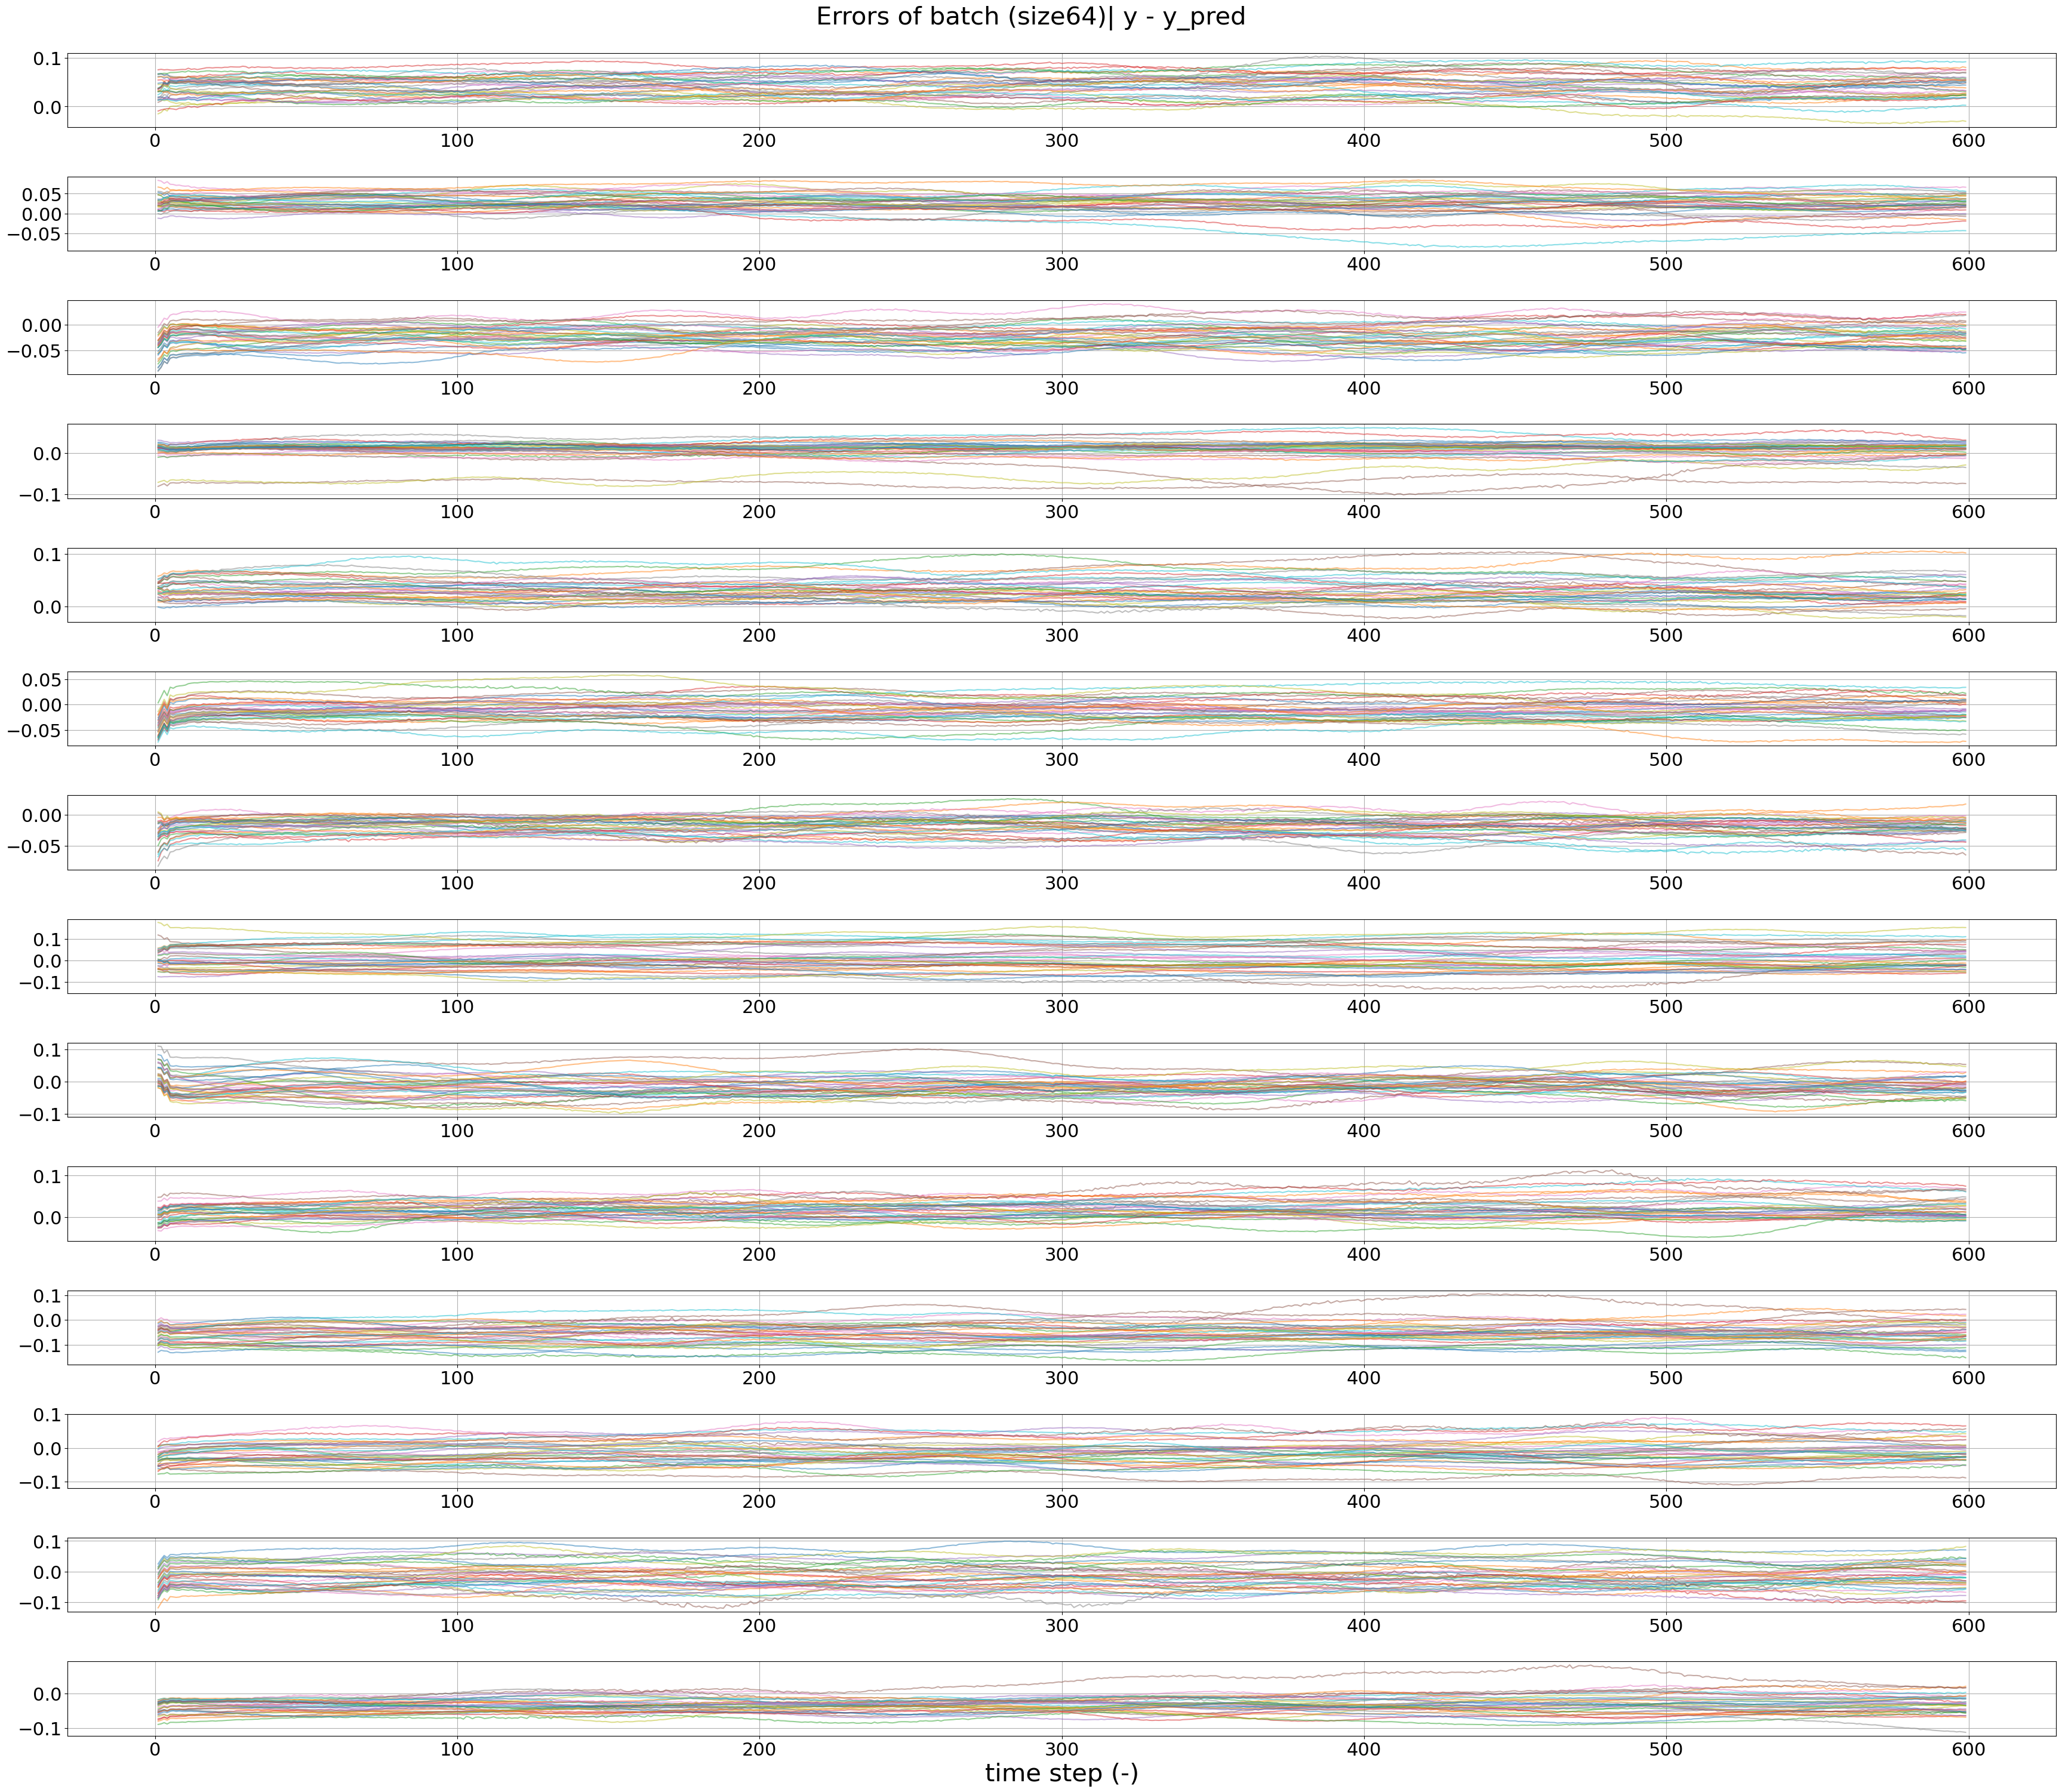

In [16]:
fig, axs = plt.subplots(ny,figsize=(35, 30))

fig.suptitle('Errors of batch (size'+str(batch_size)+')| y - y_pred',size = 30,y = .99)

labels_coordinates = ["$x$","$y$","$z$" ,"$Q_1$","$Q_2$","$Q_3$" ,"$Q_4$","q0","q1","q2","q3","q4","q5","q6"]

labels_pred = ["$\hat x$","$\hat y$","$\hat z$","$\hat Q_1$","$ \hat Q_2$","$\hat Q_3$" ,"$ \hat Q_4$"
               ,"$ \hat q0$","$ \hat q1$","$ \hat q2$","$ \hat q3$","$ \hat q4$","$ \hat q5$","$ \hat q6"]

labels_error = ["$x - \hat x$","$y - \hat y$","$z - \hat z$","$Q_1 - \hat Q_1$","$ Q_2 - \hat Q_2$",
                "$Q_3 - \hat Q_3$" ,"$ Q_4 -  \hat Q_4$","$ q0 -  \hat q0$","$ q1 -  \hat q1$","$ q2 -  \hat q2$"
                ,"$ q3 -  \hat q3$","$ q4 -  \hat q4$","$ q5 -  \hat q5$","$ q6 -  \hat q6$"]

#plt.ylim([-3, 3])
for i in range(ny):

    # axs[i].plot(t, batch_y_new[:,:,i].T, "k", alpha=0.5);
    # axs[i].plot(t, np.nan*np.zeros(t.shape), "k", alpha=1.0, label=labels_coordinates[i])
    axs[i].plot(t, batch_pred_err[:,:,i].T, alpha=0.5);
    # axs[i].plot(t, np.nan*np.zeros(t.shape), "r", alpha=1.0, label=labels_error[i]);
    axs[i].grid(True)
    
    
plt.tight_layout()
plt.xlabel("time step (-)",size = 30)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


if save_figure == True:
    plt.savefig(fig_path / f"error_one_step_{current_time}.png")


In [17]:
skip = 0
rmse_transformer = metrics.rmse(batch_y_target[:, skip:, :], batch_y_pred[:, skip:, :], time_axis=1)
nrmse_transformer = metrics.nrmse(batch_y_target[:, skip:, :], batch_y_pred[:, skip:, :], time_axis=1)
fit_index_transformer = metrics.fit_index(batch_y_target[:, skip:, :], batch_y_pred[:, skip:, :], time_axis=1)

rmse_dummy = metrics.rmse(batch_y_target[:, skip:, :], batch_y_pred_dummy[:, skip:, :], time_axis=1)


In [18]:
# print(f'iterations: {exp_data["cfg"].max_iters}')
# print(f'train_time: {exp_data["train_time"] / 3600 / 24} days')
print(f'train_time: {exp_data["train_time"] / 60} minutes')
print(f'rmse_transformer: {rmse_transformer.mean()}')
print(f'rmse_dummy: {rmse_dummy.mean()}')
print(f'nrmse_transformer: {nrmse_transformer.mean()}')
print(f'fit_index_transformer: {fit_index_transformer.mean()}')


train_time: 37.53018790483475 minutes
rmse_transformer: 0.03421558067202568
rmse_dummy: 0.0018311853054910898
nrmse_transformer: 0.5917620062828064
fit_index_transformer: 40.823795318603516
